In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from math import sqrt
import joblib

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers.legacy import Adam

In [2]:
# Load the dataset 
data1 = pd.read_excel('Data.xlsx')
data2 = data1.copy()

# Check first few rows of dataset
print(data1.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
print(data1.dtypes)
print('----')
print(data1.isna().sum())
print('----')
print(data1.describe())
print('----')
print(data1[['StockCode', 'Country', 'Description', 'InvoiceNo']].describe())

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object
----
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
----
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   389

In [12]:
def parse_dtypes(x):
    x['InvoiceDate']=pd.to_datetime(x['InvoiceDate'])
    x['StockCode'] = x['StockCode'].astype(str)
    x['InvoiceNo'] = x['InvoiceNo'].astype(str)
    return x
data1 = parse_dtypes(data1)
print(data1.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


Text(0.5, 1.0, 'Distribution of Sales Quantity')

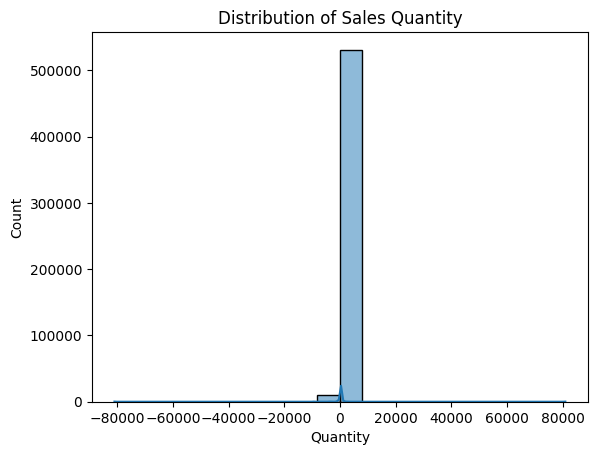

In [6]:
# Visualize data distributions

# Histogram of sales quantity
sns.histplot(data1['Quantity'], bins=20, kde=True)
plt.title('Distribution of Sales Quantity')

Text(0, 0.5, 'Sales Quantity')

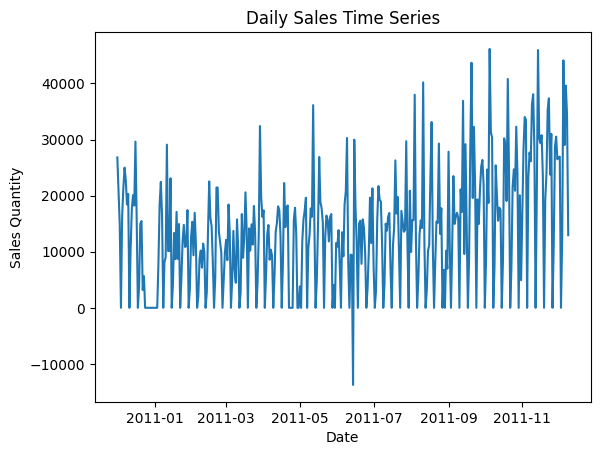

In [7]:
# Time series plot of all product sales
df = data1.copy()
df.set_index('InvoiceDate', inplace=True)
daily_sales = df.resample('D')['Quantity'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')

Text(0, 0.5, 'Sales Quantity of product 85123A')

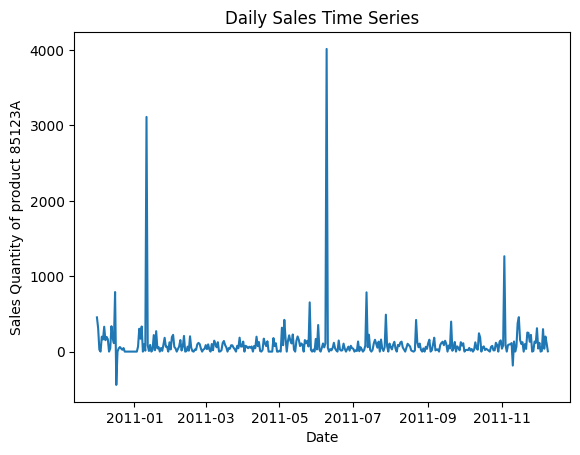

In [8]:
# Time series plot of a product sales
stock_code = "85123A"
df = data1.copy()
df.set_index('InvoiceDate', inplace=True)
df = df[df['StockCode']==stock_code]
daily_sales = df.resample('D')['Quantity'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel(f'Sales Quantity of product {stock_code}')

In [9]:
def filter_data(x):
    # # Filter the DataFrame
    # filtered_df = data1[~data1['InvoiceNo'].str.startswith('c', 'C')]
    # filtered_df
    # Create mask to filter out records with InvoiceNo starting with c
    mask = x['InvoiceNo'].str.startswith(('c', 'C'))
    print(mask.value_counts())
    print('-------------')
    mask=mask.replace(np.nan, False, regex=True)
    print(mask)
    print('--------------')
    y = x[~mask]
    print(y.shape)
    print('--------------')
    # Keep rows with quantity greater than zero
    mask = y['Quantity'] >0
    y =y[mask]
    print(y.shape)
    return y
filtered_data = filter_data(data1)

InvoiceNo
False    532621
True       9288
Name: count, dtype: int64
-------------
0         False
1         False
2         False
3         False
4         False
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Name: InvoiceNo, Length: 541909, dtype: bool
--------------
(532621, 8)
--------------
(531285, 8)


In [10]:
def groupby_singledate(x):
    agg_df = x.copy()
    # agg_df_test = filtered_data.groupby([ filtered_data['InvoiceDate'].dt.date, 'StockCode'])['Quantity'].sum()
    # print(agg_df_test)
    agg_df = x.groupby(['StockCode', x['InvoiceDate'].dt.date])['Quantity'].sum().reset_index()
    
    # Function to apply differencing for each product code
    def difference_by_product(df):
        df['Quantity_diff'] = df['Quantity'].diff()
        return df

    # Sort the DataFrame by 'ProductCode' and 'Date'
    agg_df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    
    # Apply differencing separately for each product code
    agg_df = agg_df.groupby('StockCode').apply(difference_by_product)

    # Drop NaN values created by differencing
    agg_df.dropna(inplace=True)
    agg_df.reset_index(inplace=True, drop=True)
    return  agg_df
agg_df = groupby_singledate(filtered_data)
print(agg_df)

           StockCode InvoiceDate  Quantity  Quantity_diff
0              10002  2010-12-02         1          -59.0
1              10002  2010-12-03         8            7.0
2              10002  2010-12-05         1           -7.0
3              10002  2010-12-06        25           24.0
4              10002  2010-12-07         8          -17.0
...              ...         ...       ...            ...
272897  gift_0001_40  2011-04-04         1            0.0
272898  gift_0001_40  2011-07-27         1            0.0
272899  gift_0001_50  2011-05-06         1            0.0
272900  gift_0001_50  2011-06-24         1            0.0
272901  gift_0001_50  2011-06-30         1            0.0

[272902 rows x 4 columns]


In [15]:
def extract_date_features(x):
    x['InvoiceDate']=pd.to_datetime(x['InvoiceDate'])
    x['Year'] = x['InvoiceDate'].dt.year
    x['Month'] = x['InvoiceDate'].dt.month
    x['Day'] = x['InvoiceDate'].dt.day
    x['Dayofweek']=x['InvoiceDate'].dt.dayofweek
    return x
new_agg_df = extract_date_features(agg_df)
print(new_agg_df)


           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Month  Day  \
0              10002  2010-12-02         1          -59.0  2010     12    2   
1              10002  2010-12-03         8            7.0  2010     12    3   
2              10002  2010-12-05         1           -7.0  2010     12    5   
3              10002  2010-12-06        25           24.0  2010     12    6   
4              10002  2010-12-07         8          -17.0  2010     12    7   
...              ...         ...       ...            ...   ...    ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011      4    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011      7   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011      5    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011      6   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011      6   30   

        Dayofweek  
0               3  
1          

In [16]:
def standarize_features(x):
    # Create a copy of the DataFrame to avoid modifying the original
    x_std = x.copy()
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Standardize 'Year', 'Month', and 'Day'
    x_std[['Year_normalized', 'Month_normalized', 'Day_normalized']] = scaler.fit_transform(x[['Year', 'Month', 'Day']])

    return x_std

# Apply the function to your DataFrame
new_agg_df2 = standarize_features(new_agg_df)

# Standardize 'Quantity' separately
scaler_quantity = StandardScaler()
new_agg_df2['Quantity_normalized'] = scaler_quantity.fit_transform(new_agg_df2[['Quantity']])
    
print(new_agg_df2)

           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Month  Day  \
0              10002  2010-12-02         1          -59.0  2010     12    2   
1              10002  2010-12-03         8            7.0  2010     12    3   
2              10002  2010-12-05         1           -7.0  2010     12    5   
3              10002  2010-12-06        25           24.0  2010     12    6   
4              10002  2010-12-07         8          -17.0  2010     12    7   
...              ...         ...       ...            ...   ...    ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011      4    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011      7   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011      5    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011      6   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011      6   30   

        Dayofweek  Year_normalized  Month_normalize

In [18]:
def add_avg(x):
    
    # Function to add daily and monthly avg
    def add_daily_monthly_avg(x):
        x['DailyAvg'] = x.groupby(['Dayofweek'])['Quantity'].transform('mean')
        x['MonthlyAvg'] = x.groupby(['Month'])['Quantity'].transform('mean')
        return x

    # Sort the DataFrame by 'ProductCode' and 'Date'
    x.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    
    # Apply avg separately for each product code
    x = x.groupby('StockCode').apply(add_daily_monthly_avg)
    x.reset_index(inplace=True, drop=True)
    
    return x

new_agg_df3 = add_avg(new_agg_df2)
print(new_agg_df3)

           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Month  Day  \
0              10002  2010-12-02         1          -59.0  2010     12    2   
1              10002  2010-12-03         8            7.0  2010     12    3   
2              10002  2010-12-05         1           -7.0  2010     12    5   
3              10002  2010-12-06        25           24.0  2010     12    6   
4              10002  2010-12-07         8          -17.0  2010     12    7   
...              ...         ...       ...            ...   ...    ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011      4    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011      7   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011      5    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011      6   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011      6   30   

        Dayofweek  Year_normalized  Month_normalize

In [19]:
# Create lagged features (e.g., lagged quantity for 1 and 7 days)
def create_lagged_features(x):
    df = x.copy()
    # Function to add lag values
    def add_lag_values( df):
        df['Quantity_lag_1'] =  df['Quantity'].shift(1)
        df['Quantity_lag_2'] =  df['Quantity'].shift(2)
        df['Quantity_lag_5'] =  df['Quantity'].shift(5)
        df['Quantity_lag_7'] =  df['Quantity'].shift(7)
        return  df

    # Sort the DataFrame by 'ProductCode' and 'Date'
    df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    
    # Apply differencing separately for each product code
    df =  df.groupby('StockCode').apply(add_lag_values)
    df.reset_index(inplace=True, drop=True)
    df=  df.fillna(0)
    return df

new_agg_df4=create_lagged_features(new_agg_df3)
print(new_agg_df4)

           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Month  Day  \
0              10002  2010-12-02         1          -59.0  2010     12    2   
1              10002  2010-12-03         8            7.0  2010     12    3   
2              10002  2010-12-05         1           -7.0  2010     12    5   
3              10002  2010-12-06        25           24.0  2010     12    6   
4              10002  2010-12-07         8          -17.0  2010     12    7   
...              ...         ...       ...            ...   ...    ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011      4    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011      7   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011      5    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011      6   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011      6   30   

        Dayofweek  Year_normalized  Month_normalize

In [20]:
# Create rolling features (e.g., for window size 3)
def create_rolling_features(x):
    df = x.copy()
    # Function to add rolling features
    def add_rolling_values( df):
        # Calculate rolling mean, rolling standard deviation, and rolling sum
        df['RollingMean3'] = df['Quantity'].rolling(window=3).mean()
        df['RollingMean5'] = df['Quantity'].rolling(window=5).mean()
        df['RollingMean7'] = df['Quantity'].rolling(window=7).mean()
        # df['RollingStd'] = df['Quantity_diff'].rolling(window=7).std()
        # df['RollingSum'] = df['Quantity_diff'].rolling(window=7).sum()
        
        return  df

    # Sort the DataFrame by 'ProductCode' and 'Date'
    df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    
    # Apply differencing separately for each product code
    df =  df.groupby('StockCode').apply(add_rolling_values)
    df.reset_index(inplace=True, drop=True)
    df=  df.fillna(0)
    return df

new_agg_df5=create_rolling_features(new_agg_df4)
print(new_agg_df5)

           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Month  Day  \
0              10002  2010-12-02         1          -59.0  2010     12    2   
1              10002  2010-12-03         8            7.0  2010     12    3   
2              10002  2010-12-05         1           -7.0  2010     12    5   
3              10002  2010-12-06        25           24.0  2010     12    6   
4              10002  2010-12-07         8          -17.0  2010     12    7   
...              ...         ...       ...            ...   ...    ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011      4    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011      7   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011      5    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011      6   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011      6   30   

        Dayofweek  Year_normalized  Month_normalize

In [21]:
def one_hot_encoding(x):
    encoder = LabelEncoder()
    x['StockCodeEncoded'] = encoder.fit_transform(x['StockCode'])
    x = pd.get_dummies(x, columns=[ 'StockCodeEncoded', 'Month', 'Dayofweek' ],  drop_first=True)
    return x
new_agg_df6 = one_hot_encoding(new_agg_df5)
print(new_agg_df6)

           StockCode InvoiceDate  Quantity  Quantity_diff  Year  Day  \
0              10002  2010-12-02         1          -59.0  2010    2   
1              10002  2010-12-03         8            7.0  2010    3   
2              10002  2010-12-05         1           -7.0  2010    5   
3              10002  2010-12-06        25           24.0  2010    6   
4              10002  2010-12-07         8          -17.0  2010    7   
...              ...         ...       ...            ...   ...  ...   
272897  gift_0001_40  2011-04-04         1            0.0  2011    4   
272898  gift_0001_40  2011-07-27         1            0.0  2011   27   
272899  gift_0001_50  2011-05-06         1            0.0  2011    6   
272900  gift_0001_50  2011-06-24         1            0.0  2011   24   
272901  gift_0001_50  2011-06-30         1            0.0  2011   30   

        Year_normalized  Month_normalized  Day_normalized  \
0             -3.826105          1.382291       -1.532830   
1            

In [22]:
def get_test_and_train(x):
    # Sort the DataFrame by 'date' to ensure data is in the right order
    df = x.copy(deep=True)
    df.sort_values(by=['InvoiceDate'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Do not keep invoice date as index for now
    # df.set_index('InvoiceDate', inplace=True)

    # Split the data into training and testing sets
    train_size = int(len(df) * 0.8)
    train, test = df[:train_size], df[train_size:]
  
    return train, test

train, test = get_test_and_train(new_agg_df6)
print(train.head())
print('----')
print(test.head())
print('-------')
print(len(train),len(test))


# X = new_agg_df3[features]
# y = new_agg_df3['Quantity_normalized']
# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  StockCode InvoiceDate  Quantity  Quantity_diff  Year  Day  Year_normalized  \
0     10002  2010-12-02         1          -59.0  2010    2        -3.826105   
1     37370  2010-12-02       174          146.0  2010    2        -3.826105   
2     22910  2010-12-02       135          -15.0  2010    2        -3.826105   
3     22637  2010-12-02        12          -22.0  2010    2        -3.826105   
4     22428  2010-12-02         5           -6.0  2010    2        -3.826105   

   Month_normalized  Day_normalized  Quantity_normalized  ...  Month_8  \
0          1.382291        -1.53283            -0.289263  ...    False   
1          1.382291        -1.53283             2.359123  ...    False   
2          1.382291        -1.53283             1.762088  ...    False   
3          1.382291        -1.53283            -0.120869  ...    False   
4          1.382291        -1.53283            -0.228029  ...    False   

   Month_9  Month_10  Month_11  Month_12  Dayofweek_1  Dayofweek_2  \
0   

In [ ]:
# Select features and target variable
features = [each for each in new_agg_df6.columns if each not in ['InvoiceDate', 'StockCode', 'Quantity', 'Quantity_diff', 'Quantity_normalized', 'Quantity_diff_normalized', 'Year', 'Month', 'Day', 'Year_normalized', 'Month_normalized', 'Day_normalized']]
target_varible = 'Quantity'

X_train = train[features]
y_train = train[target_varible]
X_test = test[features]
y_test = test[target_varible]
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

model_mlp = Sequential()
model_mlp.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_mlp.add(Dense(units=20, activation='relu'))
model_mlp.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_mlp.compile(loss='mse', optimizer=optimizer)
model_mlp.summary()


mlp_history = model_mlp.fit(X_train, y_train, epochs=20, verbose=2, batch_size=32)
print(mlp_history)

In [24]:

# Make predictions
y_pred = model_mlp.predict(X_test)
print(y_pred)

# # Convert predictions back to the original scale
# y_pred_original = scaler_quantity.inverse_transform(y_pred.reshape(-1, 1))
# print(y_pred_original)


# # Convert predictions back to the original scale
# test['PredictedDiff'] = y_pred_original
# y2_pred_original = agg_df['Quantity'].iloc[0] + test['PredictedDiff'].cumsum()


# print(y2_pred_original)


1706/1706 [==============================] - 1s 555us/step
[[ 4.5462537]
 [ 3.9677176]
 [24.957888 ]
 ...
 [ 1.5619739]
 [13.275236 ]
 [14.331805 ]]


In [29]:
# # Save Model
# with open('refine-nn.pkl', 'wb') as f:
#     pickle.dump(model_mlp, f)
joblib.dump(model_mlp, 'refine-nn-extended.pkl', compress=3)

['refine-nn-extended.pkl']

In [30]:
# def get_product_name_mapper(x):
#     unique_values = x[['StockCode', 'Description']].drop_duplicates().dropna() 
#     print(unique_values)

#     print(len(unique_values['StockCode'].unique()))
#     print(len(unique_values['Description'].unique()))

#     # Use list orient
#     dict = unique_values.set_index('StockCode').T.to_dict('list')

#     parsed={}
#     for each in dict:
#         parsed[each] = dict[each][0]
#     return parsed
# mapper = get_product_name_mapper(data2)

print(len(new_agg_df6['StockCode'].unique()))

3781


In [26]:
# # Convert predictions back to the original scale
# y_pred = scaler_quantity.inverse_transform(y_pred.values.reshape(-1, 1))
# print(y_pred)


# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Output Result File
test['Quantity Prediction'] = y_pred
y = test[['InvoiceDate', 'StockCode',  'Quantity', 'Quantity Prediction']]

# # Replace product codes with product names based on the mapping
# y['Product Description'] = y['StockCode'].map(mapper)
# # Handle missing product names (optional)
# y['Product Description'].fillna('Unknown', inplace=True)

y.to_csv("refine-nn-extended.csv", index=False)


Mean Absolute Error (MAE): 0.39777431653415674
Mean Squared Error (MSE): 12.307862643991577
Root Mean Squared Error (RMSE): 3.508256353801925
